# 5. Modeling - Term Deposit Subscription

## Contents
- 5.1 [Introduction](#5.1.Introduction)
- 5.2 [Initial Model Exploration](#5.2.ModelExploration)
- 5.3 [Model Selection](#5.3.ModelSelection)
- 5.4 [Hyperparameter Tuning](#5.4.HyperparameterTuning)
- 5.5 [Final Model Training](#5.5.FinalModel)
- 5.6 [Final Model Evaluation](#5.6.ModelEvaluation)
- 5.7 [Conclusion and Reccomendation](#5.7Conclusion)


### 5.1 Introduction <a id="5.1.Introduction"></a>

First, I'll begin by exploring 5 models and compare the results at baseline. Then after comparing various evaluation metrics, the model with the best metrics will be selected. Then follows the hyperparameter tuning on the best classifier using Randomized search. Once the best hyperparameters are revealed, the final model will be built and evaluated.

In [23]:
#importing relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  confusion_matrix, roc_auc_score, auc, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,  f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score


import warnings
warnings.filterwarnings("ignore")

In [24]:
X_train = pd.read_csv('X_train_subscription.csv')
X_test = pd.read_csv('X_test_subscription.csv')

y_train = pd.read_csv('y_train_subscription.csv')
y_test = pd.read_csv('y_test_subscription.csv')

In [25]:
X_train.shape

(58165, 30)

In [26]:
X_test.shape

(19389, 30)

In [27]:
y_train.shape

(58165, 1)

In [28]:
y_test.shape

(19389, 1)

### 5.2 Initial Model Exploration  <a id="5.2.ModelExploration"></a>  

With this step, I'll try to gether insights into how different algorithms behave with the dataset to get a baseline understanding of model performance before diving into more complex optimizations.

In [29]:
# list of models

models = [KNeighborsClassifier(n_neighbors=2),
          LogisticRegression(),
          RandomForestClassifier(),
          GradientBoostingClassifier(),
          SVC()]

In [30]:
def compare_classifiersCV():
    
    for model in models:
        cv_score = cross_val_score(model, X_train, y_train, cv=5)
        mean_accuracy = sum(cv_score)/len(cv_score)
        mean_accuracy = round((mean_accuracy*100), 2)
        
        y_pred = cross_val_predict(model, X_train, y_train, cv=5)
        balanced_accuracy = balanced_accuracy_score(y_train, y_pred)
        balanced_accuracy = round((balanced_accuracy *100), 2)
        
        y_pred = cross_val_predict(model, X_train, y_train, cv=5)
        f1 = f1_score(y_train, y_pred)
        f1 = round((f1), 2)
        
        y_scores = cross_val_predict(model, X_train, y_train, cv=5, method="predict")
        auc_score = roc_auc_score(y_train, y_scores)
        auc_score = round((auc_score), 2)
        
        cm = confusion_matrix(y_train, y_pred)
        
        print('Cross Validation accuracies for the', model, '=', cv_score)
        print('Accuracy score of the' , model, '=', mean_accuracy, '%')
        print('Balanced Accuracy score of the' , model, '=', balanced_accuracy, '%')
        print('F1 score of the', model, '=', f1)
        print('AUC score of the', model, '=', auc_score)
        print('Confusion Matrix of the', model, '=\n', cm)
        
        print('_____________________________________________________________')
        

In [31]:
compare_classifiersCV()

Cross Validation accuracies for the KNeighborsClassifier(n_neighbors=2) = [0.94807874 0.94962606 0.95074357 0.94653142 0.94911029]
Accuracy score of the KNeighborsClassifier(n_neighbors=2) = 94.88 %
Balanced Accuracy score of the KNeighborsClassifier(n_neighbors=2) = 94.88 %
F1 score of the KNeighborsClassifier(n_neighbors=2) = 0.95
AUC score of the KNeighborsClassifier(n_neighbors=2) = 0.95
Confusion Matrix of the KNeighborsClassifier(n_neighbors=2) =
 [[26729  2305]
 [  672 28459]]
_____________________________________________________________
Cross Validation accuracies for the LogisticRegression() = [0.81045302 0.81733001 0.82111235 0.81810367 0.81990888]
Accuracy score of the LogisticRegression() = 81.74 %
Balanced Accuracy score of the LogisticRegression() = 81.74 %
F1 score of the LogisticRegression() = 0.82
AUC score of the LogisticRegression() = 0.82
Confusion Matrix of the LogisticRegression() =
 [[24144  4890]
 [ 5732 23399]]
__________________________________________________

### 5.3 Model selection    <a id="5.3.ModelSelection"></a> 

Looking at the accuracy metric results from the 5 models, it seems like the KNeighbors Classifier and Random Forest model out perform the others.
Thus, I'll proceed with the hyperparameter tuning the two models.

### 5.4 Hyperparameter tuning <a id="5.4.HyperparameterTuning"></a>

#### 5.4. a. KNeighbors Classifier

In [35]:
param = {
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p' : [1.0, 2.0]
             }

knn =  KNeighborsClassifier(n_neighbors=2)

knn_cv= RandomizedSearchCV(knn,param,cv=5)
knn_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=2),
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'p': [1.0, 2.0],
                                        'weights': ['uniform', 'distance']})

In [36]:
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.9596492736181552
Best Parameters: {'weights': 'distance', 'p': 1.0, 'algorithm': 'kd_tree'}


In [37]:
y_pred = cross_val_predict(knn, X_train, y_train, cv=5)
balanced_accuracy = balanced_accuracy_score(y_train, y_pred)
print("Balanced Accuracy: " , round(balanced_accuracy,2))

Balanced Accuracy:  0.95


In [38]:
f1 = f1_score(y_train, y_pred)
f1 = round((f1), 2)
print("F1 Score: ", f1)

F1 Score:  0.95


In [39]:
auc_score = roc_auc_score(y_train, y_pred)
auc_score = round((auc_score), 2)
print("AUC Score: ", auc_score)

AUC Score:  0.95


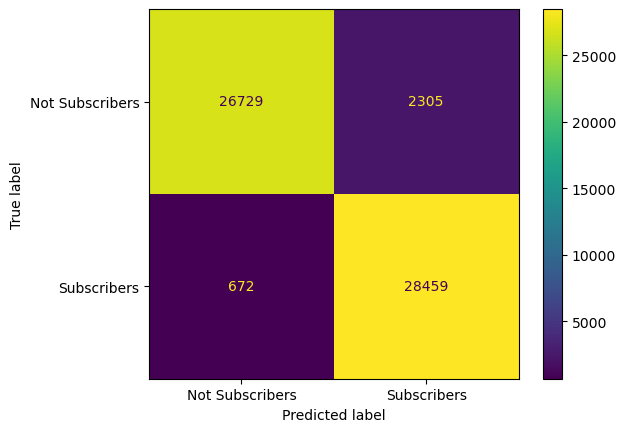

In [40]:
cm = confusion_matrix(y_train, y_pred)
class_names = ['Not Subscribers', 'Subscribers']

p = ConfusionMatrixDisplay(cm, display_labels = class_names)
p.plot()

In [41]:
report = classification_report(y_train, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     29034
           1       0.93      0.98      0.95     29131

    accuracy                           0.95     58165
   macro avg       0.95      0.95      0.95     58165
weighted avg       0.95      0.95      0.95     58165



#### 5.4. b. Random Forest Classifier

In [69]:
param = {
    'n_estimators': [10, 50, 100, 150] ,
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features' : ['sqrt', 'log2', None],
    'bootstrap' : [True, False]
}

rf =  RandomForestClassifier()

rf_cv= RandomizedSearchCV(rf,param,cv=5)
rf_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_features': ['sqrt', 'log2', None],
                                        'n_estimators': [10, 50, 100, 150]})

In [71]:
print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.976755780967936
Best Parameters: {'n_estimators': 10, 'max_features': 'sqrt', 'criterion': 'gini', 'bootstrap': False}


In [72]:
y_pred_rf = cross_val_predict(rf, X_train, y_train, cv=5)
balanced_accuracy = balanced_accuracy_score(y_train, y_pred)
print(round(balanced_accuracy,2))

0.95


In [73]:
f1 = f1_score(y_train, y_pred_rf)
f1 = round((f1), 2)
print(f1)

0.96


In [74]:
auc_score = roc_auc_score(y_train, y_pred_rf)
auc_score = round((auc_score), 2)
print(auc_score)

0.96


In [75]:
cm_rf = confusion_matrix(y_train, y_pred_rf)
cm_rf

array([[26945,  2089],
       [   61, 29070]], dtype=int64)

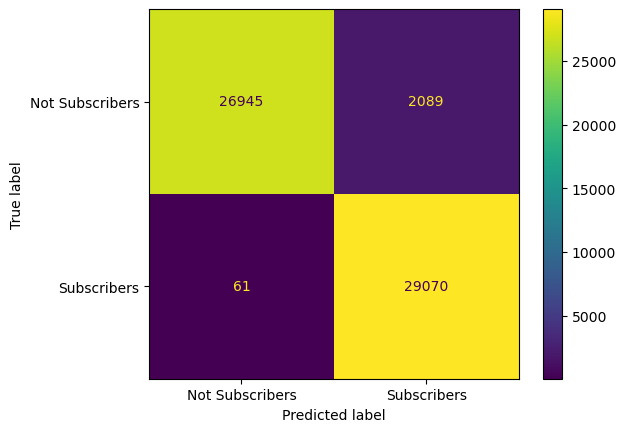

In [76]:
cm_rf = confusion_matrix(y_train, y_pred_rf)
class_names = ['Not Subscribers', 'Subscribers']

p = ConfusionMatrixDisplay(cm_rf, display_labels = class_names)
p.plot()

In [77]:
report = classification_report(y_train, y_pred_svc)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     29034
           1       0.93      1.00      0.96     29131

    accuracy                           0.96     58165
   macro avg       0.96      0.96      0.96     58165
weighted avg       0.96      0.96      0.96     58165



The hyperparameter tuning slightly imporved the models' scores.

Comparing the KNeighbor sClassifier with the Random Forest Classifier, both have the same level of balanced accuracy but the Random Forest Classifier has a slightly higher AUC and F1 score. Therefore, the Random Forest Classifier is selected for this project. 

### 5.5 Final Model Training <a id="5.5.FinalModel"></a>

In [79]:
rfc=  RandomForestClassifier( n_estimators = 10, max_features = 'sqrt', criterion = 'gini', bootstrap = False)


rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, n_estimators=10)

In [80]:
importances = rfc.feature_importances_
importances

array([0.07772138, 0.02036762, 0.0844563 , 0.07158498, 0.08198853,
       0.36385391, 0.03367111, 0.03610588, 0.01858639, 0.00859563,
       0.00332223, 0.00262312, 0.00665527, 0.00392479, 0.00363594,
       0.00506294, 0.00408009, 0.00753578, 0.00348487, 0.0009147 ,
       0.00940507, 0.00707419, 0.00170914, 0.03183935, 0.01024939,
       0.00621565, 0.0531628 , 0.0024032 , 0.02972735, 0.01004239])

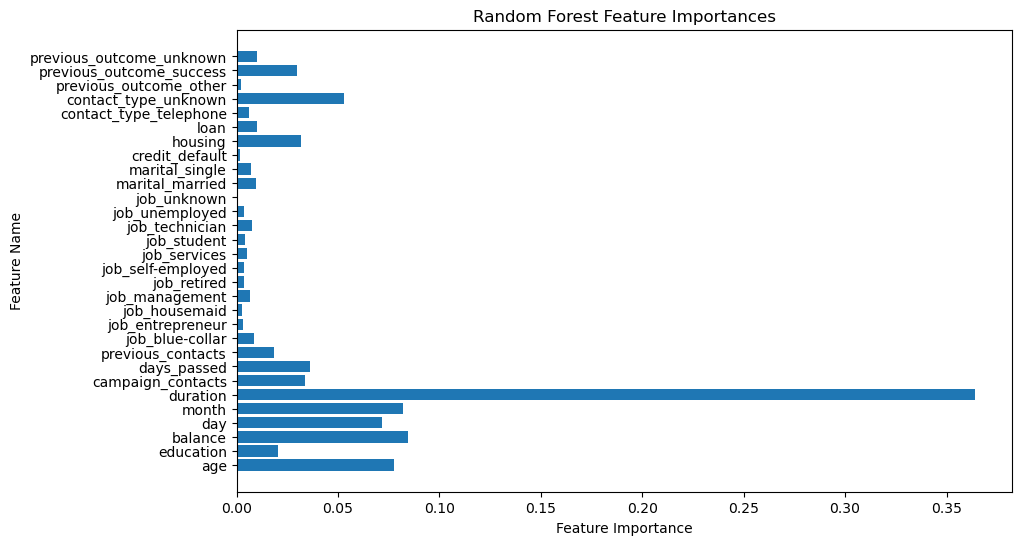

In [81]:
feature_names = X_train.columns.tolist()

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Random Forest Feature Importances')
plt.show()

* `Duration` appears to be by far the biggest predictor of subscription.

* The top features that the model showed to have the biggest impact are: `duration`, `contact_type_unknown`, `balance`, `month` and `age`.

* `Job type` and `credit default` showed to have the least impact on subscription.

### 5.6 Final Model Evaluation <a id="5.6.ModelEvaluation"></a>

In [98]:
y_probs = rfc.predict_proba(X_test)[:, 1] 

threshold = 0.65

y_pred_ = [1 if prob >= threshold else 0 for prob in y_probs]

f1 = f1_score(y_test, y_pred_)
print(f"F1 score with threshold {threshold}: {round(f1, 2)}")

F1 score with threshold 0.65: 0.99


In [99]:
accuracy = accuracy_score(y_test, y_pred_)
precision = precision_score(y_test, y_pred_)
recall = recall_score(y_test, y_pred_)

print("Accuracy : ", round(accuracy, 2))
print("Precision : ", round(precision, 2))
print("Recall : ", round(recall, 2))


Accuracy :  0.99
Precision :  0.98
Recall :  1.0


In [100]:
report_ = classification_report(y_test, y_pred_)
print(report_)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      9743
           1       0.98      1.00      0.99      9646

    accuracy                           0.99     19389
   macro avg       0.99      0.99      0.99     19389
weighted avg       0.99      0.99      0.99     19389



In [101]:
auc_roc = roc_auc_score(y_test, y_pred_)
print("AUC-ROC Score:", round(auc_roc, 2))

AUC-ROC Score: 0.99


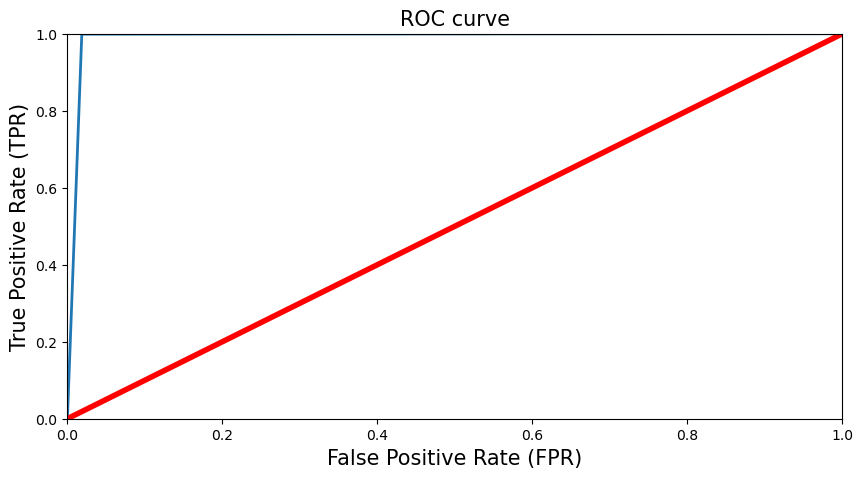

In [104]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title('ROC curve',fontsize=15)

plt.figure(figsize=(10, 5))
plot_roc_curve(fpr, tpr)
plt.show()

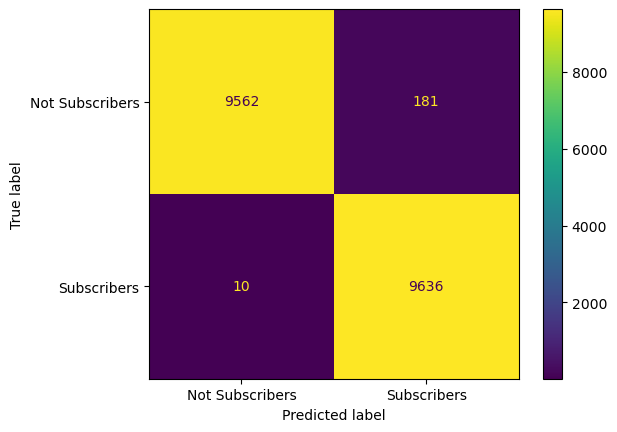

In [103]:
cm_rfc = confusion_matrix(y_test, y_pred_)
class_names = ['Not Subscribers', 'Subscribers']

disp = ConfusionMatrixDisplay(cm_rfc, display_labels = class_names)
disp.plot()

### 5.7 Conclusion and Recommendation  <a id="5.7Conclusion"></a> 

**Conclusion:**


* From the initial model exploration the evaluation metrics indicated that KNeighbors and Random Forest models performed better than others. 
* Hyperparameter tuning was conducted, and it slightly imporved both models' scores. 

* Model Comparison between KNeighbors and Random Forest models: 
Comparing the two classifiers, both have the same level of balanced accuracy but the Random Forest Classifier has a slightly higher AUC and F1 score. Therefore, the Random Forest Classifier was selected.  


* Identified the most important features impacting the model: 
The top features that the model showed to have the biggest impact are: `duration`, `contact_type_unknown`, `balance`, `month` and `age`. And `duration` appeared to be by far the biggest predictor of subscription, while, `job type` and `credit default` showed to have the least impact on subscription.

**Recommendations:**

* A prediction threshold of 0.65 was found to be ideal in this case, however, it  can be adjusted (lowered) to allow the model to capture more positive instances, potentially reducing missed positive cases which could enable the bank to maximize efforts in targeting more customers leading to a higher potential subscription. Similarly, the threshold can be increased to make the model more conservative in classifying instances as positive allowing the bank to use less resources in the campaign and focus on a smaller number of customers that are highly likely to subscribe. The decision to adjust this threshold depends on the bank's Subscription goals for future campaigns.
